In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Custom modules
from approximators import MLP, QValueApproximator
from states import EnvironmentState
from agents import LearningAgent
from data import DataGenerator

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
n_levels = 10
horizon = 100
action_size = 10
n_episodes = 30

data = DataGenerator.generator("../data/SAMPO.parquet", levels=n_levels).head(30000)

means = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].mean()
means = np.concatenate([means.values, [0, 2.5, 2.5, 4.5]])

stds = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].std()
stds = np.concatenate([stds.values, [1e4/3, 1.9, 1.9, 3]])

# Combine the two vectors in a matirx
std_values = np.vstack((means, stds)).T.astype(np.float32)

windows = []
for i in range(n_episodes):
    windows.append(data.iloc[i*(horizon+1):(i+1)*(horizon+1)])

In [3]:
min_values = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].min().values
max_values = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].max().values

min_values = np.concatenate([min_values, [-1e4, -1, -1, 0]])
max_values = np.concatenate([max_values, [1e4, 5, 5, 9]])

bounds = np.vstack((min_values, max_values)).T.astype(np.float32)

In [4]:
# model = MLP(10, 1, [64, 128, 64], torch.nn.ReLU, 0.05, device).to(device)
# q_approximator = QValueApproximator(model, 1e-4, std_values)

from approximators import TilingApproximatorMedium

q_approximator = TilingApproximatorMedium(
    bounds = bounds,
    n_tiles = 16,
    n_tilings = 128,
    # We can sample random shifts for each dimension
    shifts = np.random.uniform(0.8, 0.19, 10),
) 

In [5]:
agent = LearningAgent(
    action_size=action_size,
    q_value_approximator=q_approximator,
    epsilon=0.5,
    epsilon_decay=0.97,
    min_epsilon=0.01,
    gamma=0.99,
)

env = EnvironmentState(data, n_levels, horizon)

In [ ]:
rewards_train, losses_train, bankrolls_train = [], [], []
outstanding_orders = []
inventory = []

for episode in tqdm(range(3*n_episodes)):
    episode = episode % n_episodes
    env.data = windows[episode]
    env.reset()
    rewards, losses, bankrolls = agent.train(env, 1)

    # Track the evolution of the number of outstanding orders
    outstanding_orders.append(len(env.orders))
    inventory.append(env.inventory)
    
    rewards_train.extend(rewards)
    losses_train.extend(losses)
    bankrolls_train.extend(bankrolls)

rewards_train = pd.Series(rewards_train)
losses_train = pd.Series(losses_train)
bankrolls_train = pd.Series(bankrolls_train)
inventory = pd.Series(inventory)
outstanding_orders = pd.Series(outstanding_orders)

  0%|          | 0/90 [00:00<?, ?it/s]

Z  [[ 9.  6.  2. ... 13. 11.  4.]
 [ 9.  3.  2. ... 13. 11.  8.]
 [ 9.  3.  2. ...  7.  0. 11.]
 [ 9.  2.  2. ... 13.  5.  3.]
 [ 9.  4.  2. ...  7.  0. 11.]]
y  [0.09899966 0.09899946 0.09900008 0.0989985  0.09899969]
Z  [[ 9.  4.  2. ... 13.  5. 11.]
 [ 9.  3.  2. ...  7.  0. 15.]
 [ 9.  3.  2. ...  2. 11.  1.]
 [ 9.  3.  2. ...  7.  0.  4.]
 [ 9.  3.  2. ... 13. 11. 15.]]
y  [0.09202242 0.09418164 0.09246061 0.09773946 0.09440981]
Z  [[ 9.  3.  2. ... 13. 11. 10.]
 [ 9.  3.  2. ...  7.  0.  4.]
 [ 9.  3.  2. ...  7.  0.  4.]
 [ 9.  2.  2. ... 13. 11.  3.]
 [ 9.  3.  2. ...  7.  0.  6.]]
y  [0.09218558 0.09463491 0.09427311 0.09057761 0.08910741]
Z  [[ 9.  2.  2. ... 13. 11. 11.]
 [ 9.  3.  2. ... 13.  5.  8.]
 [ 9.  3.  2. ...  7.  0.  4.]
 [ 9.  3.  2. ... 13. 11.  4.]
 [ 9.  3.  2. ...  7.  0.  4.]]
y  [0.09058192 0.0934293  0.09712716 0.09730405 0.0974109 ]
Z  [[ 9.  3.  2. ...  7.  0.  4.]
 [ 9.  4.  2. ...  7.  0.  4.]
 [ 9.  3.  2. ...  7.  0.  4.]
 [ 9.  3.  2. ...  7.  0.  4

<Axes: >

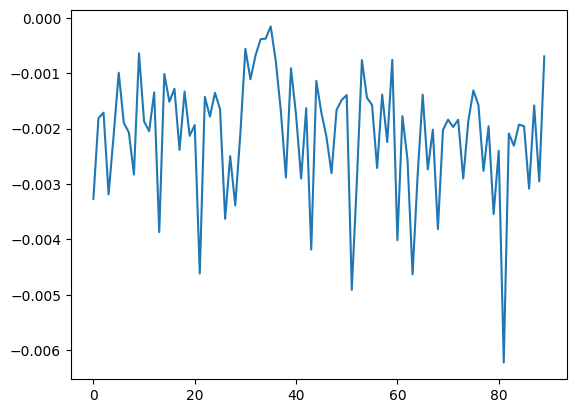

In [7]:
rewards_train.rolling(1).mean().plot()

<Axes: >

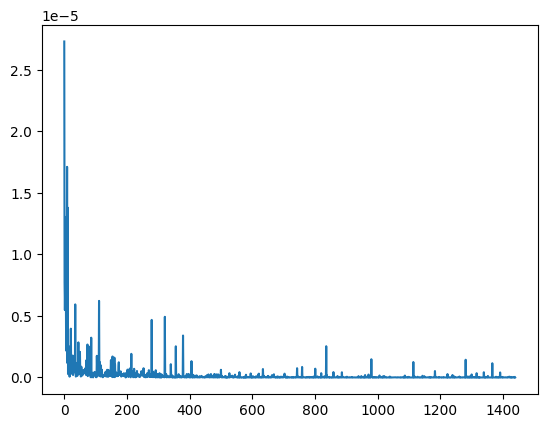

In [8]:
losses_train.rolling(1).mean().plot()

<Axes: >

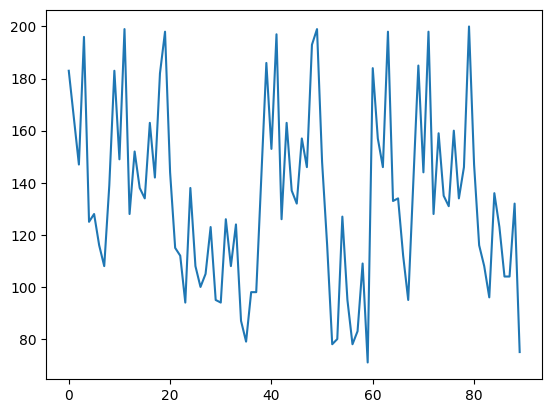

In [17]:
outstanding_orders.rolling(1).mean().plot()